In [85]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Union
from pathlib import Path
from pprint import pprint
from matplotlib.patches import Circle, Ellipse
from matplotlib.colors import LinearSegmentedColormap
mpl.rcParams.update({'font.family':'serif'})

In [2]:
def read_mesa_file(file: Union[Path, str]):
    """A simple file reader that can read a mesa .data file or a .mod model file.
    It returns all the values inside those files as an dictionary. If values
    are part of a table, they will be arrays.
    
    Inputs: A file path
    """
    if isinstance(file, str):
        file = Path(file)
    dic = {}
    with file.open('r') as fil:
        if file.suffix == ".mod":
            fil.readline()
            fil.readline()
            fil.readline()
            fil.readline()
            line = fil.readline().split()
            while len(line) > 0:
                # print(line)
                if line[1].count("'") > 0:  # Strings
                    dic[line[0]] = line[1]
                elif line[1].count('.') == 1:  # Floats, D or E
                    dic[line[0]] = float(line[1].replace('D', 'E'))
                elif line[1].isdigit():  # Ints
                    dic[line[0]] = line[1]
                line = fil.readline().split()
            keys = ["i"] + fil.readline().split()
        elif file.suffix == ".data":
                
            fil.readline()
            keys = fil.readline().split()
            vals = fil.readline().split()
            for k, v in zip(keys, vals):
                if v.count(".") == 1:
                    dic[k] = float(v)
                    if k == "Teff":
                        print(k, float(v), dic["Teff"])
                elif v.isdigit():
                    dic[k] = int(v)
                elif v.count(".") == 2:
                    dic[k] = v
                else:
                    dic[k] = None
            fil.readline()
            fil.readline()
            keys = fil.readline().split()
        # print(keys)
        line = fil.readline()
        while len(line.split()) > 0:
            for i, v in enumerate(line.split()):
                if v.count(".") == 1:
                    if keys[i] in dic.keys():
                        dic[keys[i]].append(float(v.replace('D', 'E')))
                    else:
                        dic[keys[i]] = [float(v.replace('D', 'E'))]
                elif v.isdigit():
                    if keys[i] in dic.keys():
                        dic[keys[i]].append(int(v))
                    else:
                        dic[keys[i]] = [int(v)]
                elif v.count(".") == 2:
                    if keys[i] in dic.keys():
                        dic[keys[i]].append(v)
                    else:
                        dic[keys[i]] = [v]
                else:
                    if keys[i] in dic.keys():
                        dic[keys[i]].append(None)
                    else:
                        dic[keys[i]] = [None]
                    keys[i]
            line = fil.readline()
        for key, item in dic.items():
            if isinstance(item, list):
                dic[key] = np.array(item)
    return dic

In [3]:
def planck(lamda, Teff):
    lhs = 2 * 6.626e-34 * 2.9979e8 * 2.9979e8 / lamda**5
    exp = 6.626e-34 * 2.9979e8 / lamda / 1.3806e-23 / Teff
    result = lhs / (np.exp(exp) - 1)
    return result

def color_temp(Teff):
    lamdas = np.arange(300, 800, 10) * 1e-9
    fluxes = planck(lamdas, Teff)
    blue = np.sum(fluxes[(lamdas > 400e-9) & (lamdas < 490e-9)])
    green = np.sum(fluxes[(lamdas > 485e-9) & (lamdas < 570e-9)])
    red = np.sum(fluxes[(lamdas > 565e-9) & (lamdas < 660e-9)])
    color = np.array([red, green, blue])
    color = color / np.max(color)
    return color

In [4]:
here = Path()
print(here.absolute())
models = []
for i, fil in enumerate(here.glob("*final_model*.mod")):
    models.append(read_mesa_file(fil))
    if models[i]["M/Msun"] == 1.0:
        solar_ind = i
# pprint(models)
mdl = read_mesa_file(fil)
pprint(mdl.keys())
print(f"Solar Model is at Index {solar_ind}")

/home/dgatlin/Documents/2022/astr_565/assignment_16.1
dict_keys(['version_number', 'M/Msun', 'model_number', 'star_age', 'initial_z', 'n_shells', 'net_name', 'species', 'Teff', 'power_nuc_burn', 'power_h_burn', 'power_he_burn', 'power_z_burn', 'power_photo', 'total_energy', 'cumulative_energy_error', 'cumulative_error/total_energy', 'num_retries', 'i', 'lnd', 'lnT', 'lnR', 'L', 'dq', 'mlt_vc', 'h1', 'he3', 'he4', 'c12', 'n14', 'o16', 'ne20', 'mg24'])
Solar Model is at Index 12


In [121]:
def set_lumen_ticks(x, y):
    first_try = f"{x:.2e}"
    lbrace = '{'
    rbrace = '}'
    base, ex = first_try.replace('+', '').split('e')
    ex = ex.lstrip('0')
    ex = ex.replace("-0", "-")
    if "1.0" in base:
        base = ""
    else:
        base += r"\times"
    latex_str = f"${base}10^{lbrace}{ex}{rbrace}L_\odot$"
    if ex == "":
        latex_str = "$L_\odot$"
    elif ex == "1":
        latex_str = f"$10L_\odot$"
    return latex_str

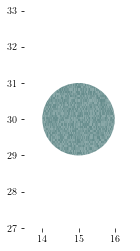

In [122]:
def plot_point(ax, x_val, y_val, rad, model):
    high_color = color_temp(model["Teff"])
    low_color = color_temp(0.6 * model["Teff"])
    color_path = {'red':   [(0.0,  0.0, high_color[0]),
                            (1.0,  low_color[0], 1.0)],

                  'green': [(0.0,  0.0, high_color[1]),
                            (1.0,  low_color[1], 1.0)],

                  'blue':  [(0.0,  0.0, high_color[1]),
                            (1.0,  low_color[1], 1.0)]}
    custom_map = LinearSegmentedColormap("This Star", color_path)
    # width =  np.exp(model["lnR"][-1]) / np.exp(models[solar_ind]["lnR"][-1]) * 1000
    circle = Circle((x_val, y_val), rad,
                    facecolor="none", edgecolor="none")
    ax.add_patch(circle)
    bg = plt.imshow(np.random.random((100, 100)), origin="lower",
                   cmap=custom_map, interpolation="nearest",
                   extent=[x_val * 0.9, x_val * 1.1, y_val * 0.9, y_val * 1.1])
    bg.set_clip_path(circle)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.grid(False)
ax.set_facecolor((1, 1, 1))
x_range = (30000, 3000)
y_range = (1e-2, 1e5)
width = 1000
height = width * x_val / y_val * 0.7
rad = 1
plot_point(ax,
           15, 30, rad,
        #    mdl["Teff"], mdl["L"][-1] / models[solar_ind]["L"][-1],
           mdl)
# ax.set_xlim(*x_range)
# ax.set_ylim(*y_range)
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()

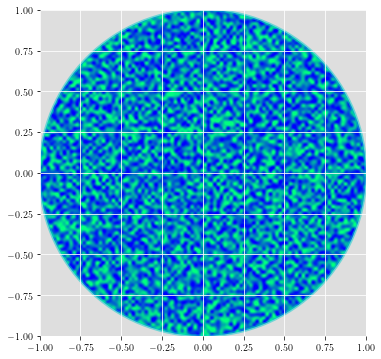

In [123]:
np.random.seed(19680801)


r = np.random.rand(50)
t = np.random.rand(50) * np.pi * 2.0
x = r * np.cos(t)
y = r * np.sin(t)

fig, ax = plt.subplots(figsize=(6, 6))
circle = Circle((0, 0), 1, facecolor='none',
                edgecolor=(0, 0.8, 0.8), linewidth=3, alpha=0.5)
ax.add_patch(circle)

im = plt.imshow(np.random.random((100, 100)),
                origin='lower', cmap="winter",
                interpolation='spline36',
                extent=([-1, 1, -1, 1]))
im.set_clip_path(circle)

# plt.plot(x, y, 'o', color=(0.9, 0.9, 1.0), alpha=0.8)

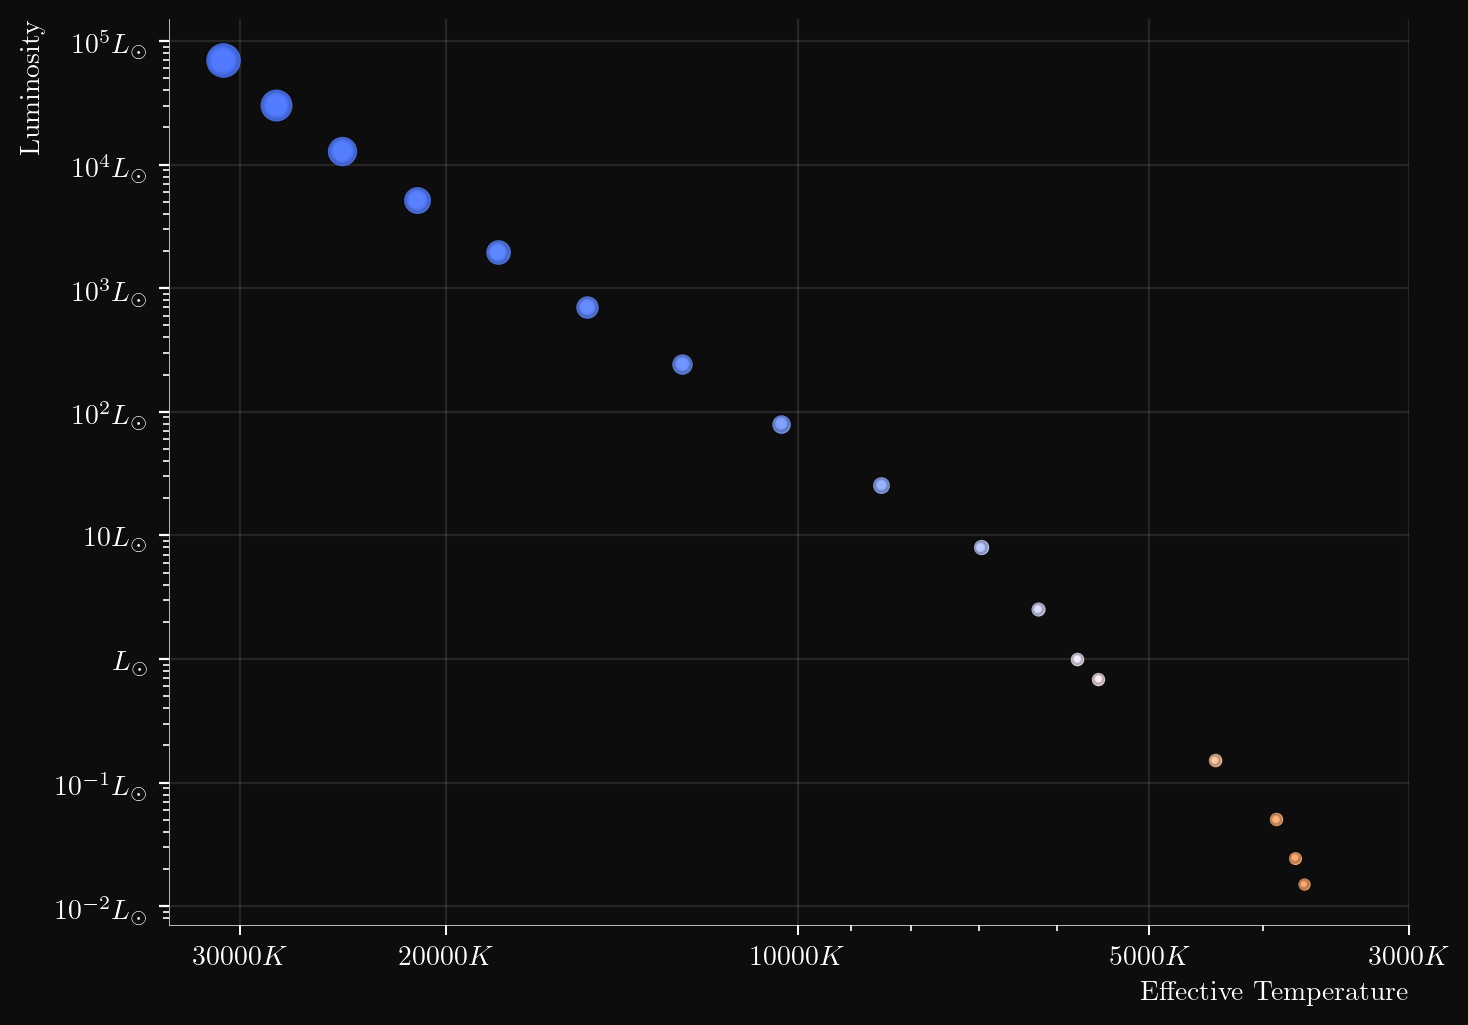

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)
for model in models:
    x_val = model["Teff"]
    y_val = model["L"].max() / models[solar_ind]["L"].max()
    ax.scatter(model["Teff"], model["L"].max() / models[solar_ind]["L"].max(),
               color=color_temp(model["Teff"]),
               s=np.exp(model["lnR"][-1]) / np.exp(models[solar_ind]["lnR"][-1])
               * 15,
               zorder=10)
    for i in range(10):
        ax.scatter(model["Teff"], model["L"].max() / models[solar_ind]["L"].max(),
                   color='k', alpha=0.15 * (11 - i)/11, facecolor="none", edgecolors='k',
                   s=np.exp(model["lnR"][-1]) / np.exp(models[solar_ind]["lnR"][-1])
                   * (17 - i), zorder=15)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, alpha=0.1)
ax.invert_xaxis()
ax.set_frame_on(True)
ax.set_xlabel(r"Effective Temperature")
ax.xaxis.label.set_color("white")
ax.yaxis.label.set_color("white")
# ax.xaxis.tick_bottom.set_color("white")
# ax.yaxis.label.set_color("white")
ax.set_ylabel(r"Luminosity")
fig.set_facecolor([0.05, 0.05, 0.05])
ax.set_facecolor([0.05, 0.05, 0.05])
ax.tick_params(axis="both", which="both", colors="white")
ax.spines["bottom"].set_color("white")
ax.spines["bottom"].set_linewidth(0.25)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_color("white")
ax.spines["left"].set_linewidth(0.25)
ax.spines["left"].set_visible(True)
ax.xaxis.set_major_formatter("${x:.0f}K$")
ax.xaxis.set_ticks([3000, 5000, 10000, 20000, 30000])
ax.xaxis.set_visible(True)
ax.yaxis.set_major_formatter(set_lumen_ticks)
fig.savefig("hr_diagram.png", dpi=200)


In [125]:
fmanager = mpl.font_manager.FontManager()

In [8]:
fmanager.defaultFamily

{'ttf': 'DejaVu Sans', 'afm': 'Helvetica'}

In [9]:
mpl.matplotlib_fname()

'/home/dgatlin/.pyenv/versions/3.9.7/envs/snakes/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'